# Common raster operations

# Creating a raster mosaic with `rioxarray`

Merging raster files

In [1]:
import xarray as xr 
import os 
import rioxarray as rxr 
from rioxarray.merge import merge_datasets

In [7]:
bucket = "https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/PythonGIS"

# Generate urls for the elevation files
urls = [
    os.path.join(bucket, "elevation/kilimanjaro/ASTGTMV003_S03E036_dem.tif"),
    os.path.join(bucket, "elevation/kilimanjaro/ASTGTMV003_S03E037_dem.tif"),
    os.path.join(bucket, "elevation/kilimanjaro/ASTGTMV003_S04E036_dem.tif"),
    os.path.join(bucket, "elevation/kilimanjaro/ASTGTMV003_S04E037_dem.tif"),
]

# Read the files
datasets = [
    xr.open_dataset(url, engine="rasterio").squeeze("band", drop=True) for url in urls
]

In [4]:
print(datasets[0])

<xarray.Dataset> Size: 52MB
Dimensions:      (x: 3601, y: 3601)
Coordinates:
  * x            (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0 37.0
  * y            (y) float64 29kB -2.0 -2.0 -2.001 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float32 52MB ...


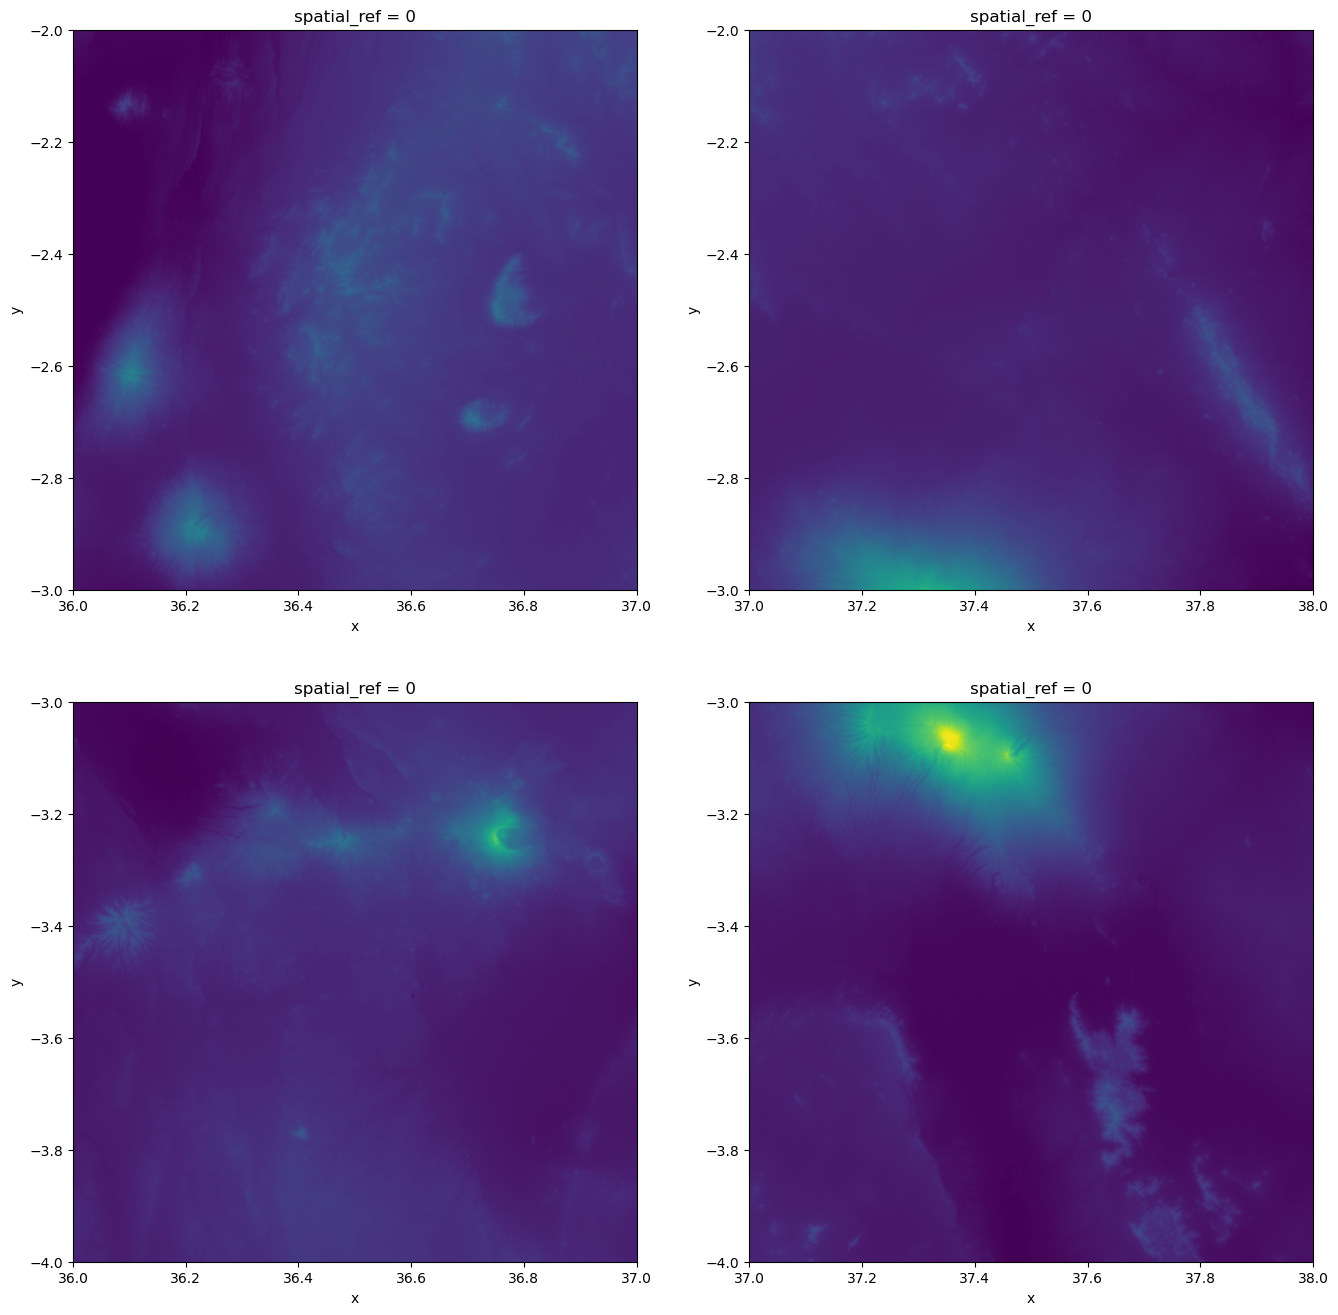

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Plot the tiles to see how they look separately
datasets[0]["band_data"].plot(ax=axes[0][0], vmax=5900, add_colorbar=False)
datasets[1]["band_data"].plot(ax=axes[0][1], vmax=5900, add_colorbar=False)
datasets[2]["band_data"].plot(ax=axes[1][0], vmax=5900, add_colorbar=False)
datasets[3]["band_data"].plot(ax=axes[1][1], vmax=5900, add_colorbar=False)

>combine the four into a mosaic

In [10]:
mosaic = merge_datasets(datasets)
mosaic = mosaic.rename({"band_data":"elevation"})

/nix/store/dabb6lrwhq8gr8gpjhqysim6wpwgj9yl-python3-3.12.7-env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  exec(code_obj, self.user_global_ns, self.user_ns)


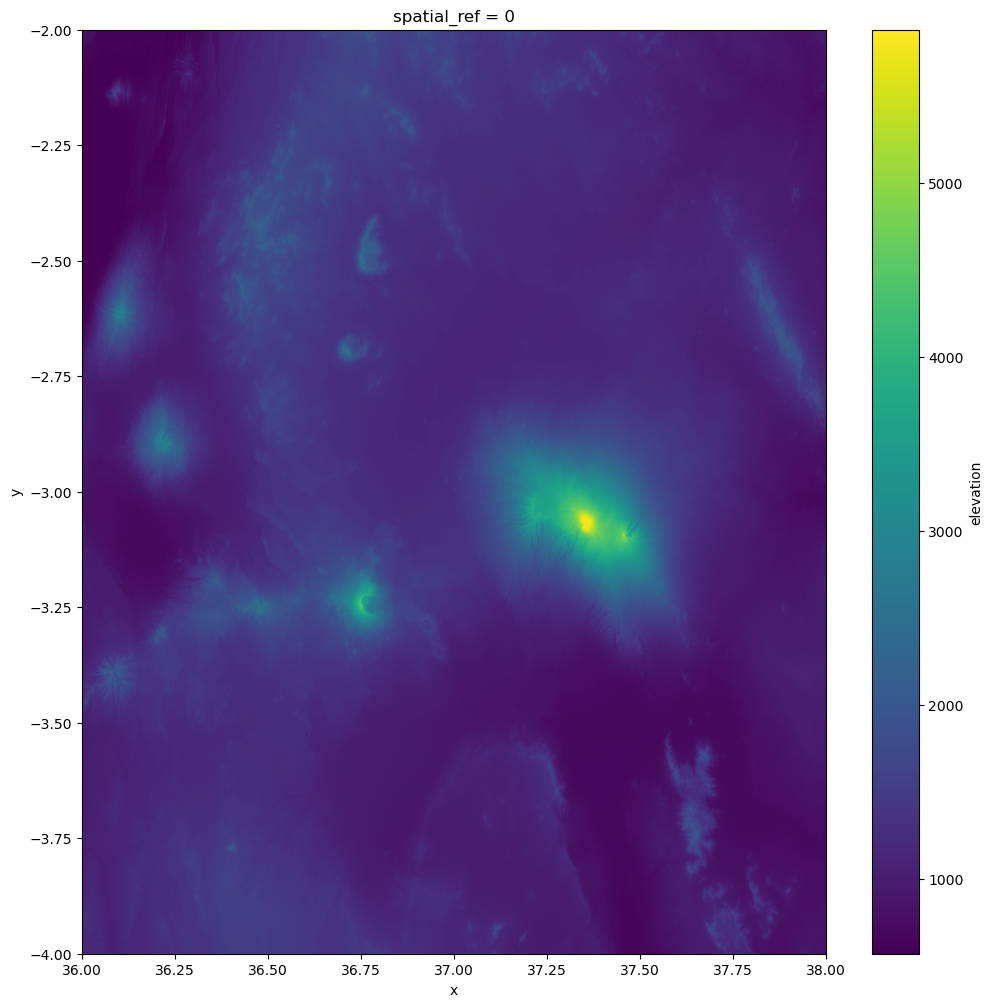

In [11]:
mosaic["elevation"].plot(figsize=(12,12))

# Clipping rasters

>Create GeoDataFrame with bounding box for clipping

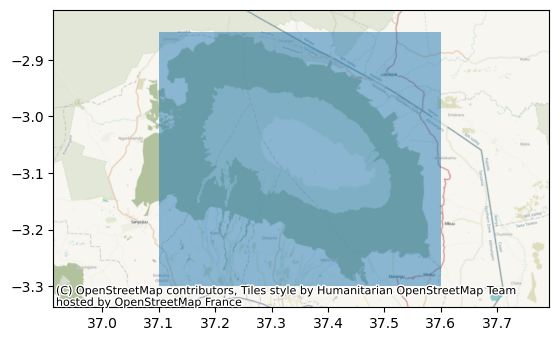

In [17]:
import geopandas as gpd 
from shapely import box 
import contextily as ctx

minx = 37.1
miny = -3.3
maxx = 37.6
maxy = -2.85

geom = box(minx, miny, maxx, maxy)
clipping_gdf = gpd.GeoDataFrame({"geometry": [geom]}, index=[0], crs="epsg:4326")

ax = clipping_gdf.plot(alpha=0.5)
ctx.add_basemap(ax, crs=clipping_gdf.crs, reset_extent=False);

>Clip the mosaic

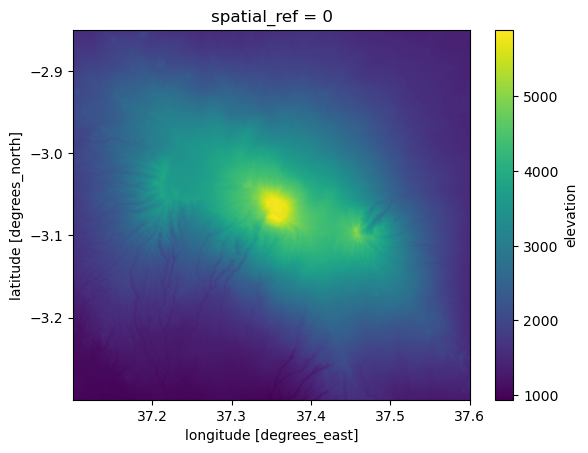

In [18]:
kilimanjaro = mosaic.rio.clip(clipping_gdf.geometry, 
                              crs=mosaic.elevation.rio.crs)
kilimanjaro["elevation"].plot()

In [19]:
print(kilimanjaro)

<xarray.Dataset> Size: 12MB
Dimensions:      (x: 1800, y: 1620)
Coordinates:
  * x            (x) float64 14kB 37.1 37.1 37.1 37.1 ... 37.6 37.6 37.6 37.6
  * y            (y) float64 13kB -2.85 -2.85 -2.851 ... -3.299 -3.299 -3.3
    spatial_ref  int64 8B 0
Data variables:
    elevation    (y, x) float32 12MB 1.581e+03 1.581e+03 ... 1.295e+03 1.294e+03
